# LSTM-Model Basic

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import pytorch_lightning as pl
from torch.utils.data import Dataset
from torchmetrics import Accuracy
import pandas as pd

from sklearn.metrics import accuracy_score
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from lstm_utils.sequence_model import SequenceModel
from lstm_utils.species_dataset import SpeciesDataset
from lstm_utils.data_loader import DataLoader
from lstm_utils.species_data_module import SpeciesDataModule
from lstm_utils.species_predictor import SpeciesPredictor

Seed set to 42


In [2]:
pl.seed_everything(42)
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Seed set to 42


Using device: cpu


In [3]:
def get_ids_with_most_common_sample_count(df, id_column="id"):
    counts = df[id_column].value_counts()
    most_common_count = counts.value_counts().idxmax()
    matching_ids = counts[counts == most_common_count].index.tolist()
    print(f"Most common sample count: {most_common_count}")
    return matching_ids


def df_to_sequences(df):
    sequences = []
    for _, group in df.groupby("id"):
        X = group[feature_columns]
        y = group[label_column].iloc[0]  
        sequences.append((X, y))
    return sequences


def weighted_accuracy(y_true, y_pred):
    class_counts = Counter(y_true)
    sample_weights = [
        1.0 / class_counts[y] for y in y_true
    ]  
    return accuracy_score(y_true, y_pred, sample_weight=sample_weights)



def get_predictions(model, dataloader, device="cpu"):
    model.eval()
    predictions = []
    labels = []
    with torch.no_grad():
        for batch in dataloader:
            seq_batch = batch["sequence"].to(device)
            label_batch = batch["label"].to(device)
            outputs = model(seq_batch)
            preds = torch.argmax(outputs, dim=1)
            predictions.extend(preds.cpu().tolist())
            labels.extend(label_batch.cpu().tolist())
    return labels, predictions

In [4]:
train_path = "../../../data/baseline_training/trainset.csv"
val_path = "../../../data/baseline_training/valset.csv"
test_path = "../../../data/baseline_training/testset.csv"



loader = DataLoader()
train_df = loader.load_transform(train_path)
val_df = loader.load_transform(val_path)
test_df = loader.load_transform(test_path)

# train_ids = set(get_ids_with_most_common_sample_count(train_df))
# val_ids   = set(get_ids_with_most_common_sample_count(val_df))
# test_ids  = set(get_ids_with_most_common_sample_count(test_df))



# train_df = train_df[train_df["id"].isin(train_ids)].copy()
# val_df   = val_df[val_df["id"].isin(val_ids)].copy()
# test_df  = test_df[test_df["id"].isin(test_ids)].copy()

# print(train_df.shape)
# print(val_df.shape)
# print(test_df.shape)

In [5]:
feature_columns = [
    col
    for col in train_df.columns
    if col not in ["id", "time", "species", "disturbance_year"]
]
label_column = "species"

le = LabelEncoder()
le.fit(train_df[label_column])             
train_df[label_column] = le.transform(train_df[label_column])
val_df[label_column]   = le.transform(val_df[label_column])
test_df[label_column]  = le.transform(test_df[label_column])

n_classes = len(le.classes_)


train_sequences = df_to_sequences(train_df)
val_sequences = df_to_sequences(val_df)
test_sequences = df_to_sequences(test_df)
train_sequences[0]

(       doy     b2     b3     b4     b5      b6      b7      b8     b8a  \
 0     13.0  176.0  229.0   69.0  329.0   996.0  1113.0  1067.0  1222.0   
 1     27.0  382.0  429.0  205.0  405.0  1192.0  1308.0  1316.0  1529.0   
 2     50.0  240.0  382.0  259.0  544.0  1387.0  1609.0  1825.0  1762.0   
 3     86.0  244.0  375.0  287.0  579.0  1536.0  1776.0  1878.0  1884.0   
 4    117.0  215.0  327.0  274.0  548.0  1499.0  1803.0  1766.0  1957.0   
 ..     ...    ...    ...    ...    ...     ...     ...     ...     ...   
 132  245.0  417.0  617.0  534.0  845.0  2132.0  2406.0  2538.0  2767.0   
 133  285.0  273.0  446.0  384.0  659.0  1673.0  2229.0  2246.0  2413.0   
 134  287.0  176.0  292.0  206.0  475.0  1385.0  1632.0  1642.0  1838.0   
 135  300.0  467.0  642.0  492.0  824.0  1927.0  2187.0  2538.0  2430.0   
 136  301.0  248.0  481.0  286.0  585.0  1762.0  1969.0  2291.0  2184.0   
 
         b11    b12  
 0     298.0  139.0  
 1     396.0  180.0  
 2     732.0  338.0  
 3    1013

In [6]:


class PaddedSpeciesDataset(Dataset):
    def __init__(self, sequences, pad_value=0.0, max_len=None):
        self.sequences = sequences
        self.pad_value = pad_value
        self.max_len = max_len if max_len is not None else max(len(X) for X, _ in sequences)

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        X, y = self.sequences[idx]
        if isinstance(X, pd.DataFrame):
            X = X.values
        seq_len, n_features = X.shape
        padded_X = np.full((self.max_len, n_features), self.pad_value, dtype=np.float32)
        padded_X[:seq_len, :] = X
        return {
            "sequence": torch.tensor(padded_X, dtype=torch.float32),
            "label": torch.tensor(y, dtype=torch.long),
            "length": seq_len
        }


# Maximal mögliche Länge aus dem Trainingsdatensatz bestimmen
max_len_train = max(len(X) for X, _ in train_sequences)
train_sequences = PaddedSpeciesDataset(train_sequences, max_len=max_len_train)
val_sequences   = PaddedSpeciesDataset(val_sequences,   max_len=max_len_train)
test_sequences  = PaddedSpeciesDataset(test_sequences,  max_len=max_len_train)


In [7]:
# %load_ext tensorboard
# %tensorboard --logdir ./lightning_logs

In [8]:

n_features = len(feature_columns)
n_classes = len(set(train_df[label_column]))
batch_size = 4
lr = 1e-3
max_epochs = 2

# DataModule & Model
data_module = SpeciesDataModule(
    train_sequences, val_sequences, test_sequences, batch_size=batch_size
)
model = SpeciesPredictor(n_features=n_features, n_classes=n_classes, lr=lr)

# Trainer
trainer = pl.Trainer(
    max_epochs=max_epochs,
    accelerator="gpu" if device=="cuda" else "cpu",
    devices=1,  
    log_every_n_steps=10,
    deterministic=True,

)
trainer.fit(model, datamodule=data_module)

/Users/rafaelriesle/Documents/Rafael Riesle/Studium/Semster 7/AWP2/tree_classification/venv/lib/python3.11/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025-10-09 11:58:22.875875: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate comp

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/multiprocessing/spawn.py", line 122, in spawn_main
    exitcode = _main(fd, parent_sentinel)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/multiprocessing/spawn.py", line 132, in _main
    self = reduction.pickle.load(from_parent)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: Can't get attribute 'PaddedSpeciesDataset' on <module '__main__' (built-in)>

Detected KeyboardInterrupt, attempting graceful shutdown ...


SystemExit: 1

/Users/rafaelriesle/Documents/Rafael Riesle/Studium/Semster 7/AWP2/tree_classification/venv/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3707: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [ ]:
# Train
train_labels, train_preds = get_predictions(
    model, data_module.train_dataloader(), device=device
)
train_weighted_acc = weighted_accuracy(train_labels, train_preds)

# Validation
val_labels, val_preds = get_predictions(
    model, data_module.val_dataloader(), device=device
)
val_weighted_acc = weighted_accuracy(val_labels, val_preds)

# Test
test_labels, test_preds = get_predictions(
    model, data_module.test_dataloader(), device=device
)
test_weighted_acc = weighted_accuracy(test_labels, test_preds)

print(f"Weighted Accuracy (Train): {train_weighted_acc:.4f}")
print(f"Weighted Accuracy (Validation): {val_weighted_acc:.4f}")
print(f"Weighted Accuracy (Test): {test_weighted_acc:.4f}")

Weighted Accuracy (Train): 0.3789
Weighted Accuracy (Validation): 0.3411
Weighted Accuracy (Test): 0.2897


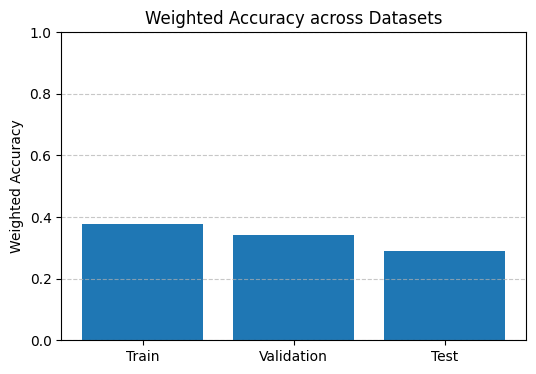

In [ ]:
metrics = {
    "Train": train_weighted_acc,
    "Validation": val_weighted_acc,
    "Test": test_weighted_acc,
}

plt.figure(figsize=(6, 4))
plt.bar(metrics.keys(), metrics.values())
plt.ylim(0, 1)
plt.ylabel("Weighted Accuracy")
plt.title("Weighted Accuracy across Datasets")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()
